In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

datapath = "/content/gdrive/My Drive/Datasets/"

import warnings
warnings.filterwarnings('ignore')

# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, log_loss
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer

import random as r
from time import time

# Helper Functions

In [3]:
def breaker():
  print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
  breaker()
  print(x[:no_of_ele])
  breaker()

def getCol(x):
  return [col for col in x.columns]

def cleaner(x=None, *args, train=True):
  df = x.copy()
  df[args[0]].loc[df[args[0]] == " ?"] = " Private"
  df[args[1]].loc[df[args[1]] == " ?"] = " Prof-specialty"
  df[args[2]].loc[df[args[2]] == " ?"] = " United-States"
  if not train:
    df["Salary"].loc[df["Salary"] == " <=50K."] = " <=50K"
    df["Salary"].loc[df["Salary"] == " >50K."]  = " >50K"
  return df

def preprocess(x, *args):
  df = x.copy()
  df[args[0]] = df[args[0]].map({' State-gov' : 0, ' Self-emp-not-inc' : 1, ' Private' : 2, ' Federal-gov' : 3,
                                 ' Local-gov' : 4, ' Self-emp-inc' : 5, ' Without-pay' : 6, ' Never-worked' : 7})
  df[args[1]] = df[args[1]].map({' Never-married' : 0, ' Married-civ-spouse' : 1, ' Divorced' : 2,' Married-spouse-absent' : 3, 
                                 ' Separated' : 4, ' Married-AF-spouse' : 5, ' Widowed' : 6})
  df[args[2]] = df[args[2]].map({' Adm-clerical' : 0, ' Exec-managerial' : 1, ' Handlers-cleaners' : 2,' Prof-specialty' : 3, ' Other-service' : 4, 
                                 ' Sales' : 5, ' Craft-repair' : 6, ' Transport-moving' : 7, ' Farming-fishing': 8, ' Machine-op-inspct' : 9, 
                                 ' Tech-support' : 10, ' Protective-serv' : 11, ' Armed-Forces' : 12, ' Priv-house-serv' : 13})
  df[args[3]] = df[args[3]].map({' Male' : 0, 'Female' : 1})
  df[args[4]] = df[args[4]].map({' White' : 0, ' Black' : 1, ' Asian-Pac-Islander' : 2, ' Amer-Indian-Eskimo' : 3, ' Other' : 4})
  df[args[5]] = df[args[5]].map({' <=50K' : 0, ' >50K' : 1}) 
  return df

def evalXGB(X_train=None, X_valid=None, y_train=None, y_valid=None, n_est=None):
  for n in n_est:
    xgb = XGBClassifier(random_state=0, n_estimators=n)
    xgb.fit(X_train, y_train)
    y_hat = xgb.predict(X_valid)
    y_hat_proba = xgb.predict_proba(X_valid)

    breaker()
    print("Accuracy {n} : {:.5f}".format(accuracy_score(y_valid, y_hat), n=n))
    print("F1 Score {n} : {:.5f}".format(f1_score(y_valid, y_hat), n=n))
    print("Log Loss {n} : {:.5f}".format(log_loss(y_valid, y_hat_proba), n=n))
  breaker()

le = LabelEncoder()
si = SimpleImputer(missing_values=np.nan, strategy="mean")

# Data Handling

**Inputs**

In [4]:
tr_dataset = pd.read_csv(datapath + "adult_train.csv", header=None)
ts_dataset = pd.read_csv(datapath + "adult_test.csv", header=None)

columns = ["Age", "Work_Class", "fnlwgt", "Education", "Education_Num", "Martial_Status", "Occupation", "Relationship", "Race", "Sex", 
           "Capital_Gain", "Capital_Loss", "Hours_Per_Week", "Native_Country", "Salary"]

tr_dataset.columns = columns
ts_dataset.columns = columns

breaker()
print(tr_dataset.head(5))
print(tr_dataset.shape)
breaker()
print(ts_dataset.head(5))
print(ts_dataset.shape)
breaker()


------------------------------

   Age         Work_Class  fnlwgt  ... Hours_Per_Week  Native_Country  Salary
0   39          State-gov   77516  ...             40   United-States   <=50K
1   50   Self-emp-not-inc   83311  ...             13   United-States   <=50K
2   38            Private  215646  ...             40   United-States   <=50K
3   53            Private  234721  ...             40   United-States   <=50K
4   28            Private  338409  ...             40            Cuba   <=50K

[5 rows x 15 columns]
(32561, 15)

------------------------------

   Age  Work_Class  fnlwgt  ... Hours_Per_Week  Native_Country   Salary
0   25     Private  226802  ...             40   United-States   <=50K.
1   38     Private   89814  ...             50   United-States   <=50K.
2   28   Local-gov  336951  ...             40   United-States    >50K.
3   44     Private  160323  ...             40   United-States    >50K.
4   18           ?  103497  ...             30   United-States   <=50K.

**Preprocessing**

In [5]:
tr_data_clean = cleaner(tr_dataset, "Work_Class", "Occupation", "Native_Country", train=True)
ts_data_clean = cleaner(ts_dataset, "Work_Class", "Occupation", "Native_Country", train=False)

tr_data = preprocess(tr_data_clean, "Work_Class", "Martial_Status", "Occupation", "Sex", "Race", "Salary")
tr_data = tr_data.drop(labels="Education", axis=1)
tr_data = tr_data.drop(labels="Relationship", axis=1)
tr_data = tr_data.values
tr_data[:, -2] = le.fit_transform(tr_data[:, -2])
tr_data = si.fit_transform(tr_data)

ts_data = preprocess(ts_data_clean, "Work_Class", "Martial_Status", "Occupation", "Sex", "Race", "Salary")
ts_data = ts_data.drop(labels="Education", axis=1)
ts_data = ts_data.drop(labels="Relationship", axis=1)
ts_data = ts_data.values
ts_data[:, -2] = le.transform(ts_data[:, -2])
ts_data = si.transform(ts_data)

# XGB

**Estimator Tuning**

In [6]:
# ns = [i*100 for i in range(1, 11)]

# X_train, X_valid, y_train, y_valid = train_test_split(tr_data[:, :-1], tr_data[:, -1], test_size=0.2, random_state=0)
# evalXGB(X_train, X_valid, y_train, y_valid, ns)
# 700 Estimators gives the best results

**Seed Averaged Results**

In [7]:
r.seed(0)
seeders = [r.randint(0,99) for i in range(25)]
accs = []
f1_s = []
logs = []

start_time = time()

for seed in seeders:
  xgb = XGBClassifier(tree_method="gpu_hist", random_state=0, n_estimators=700)
  xgb.fit(tr_data[:, :-1], tr_data[:, -1])
  y_hat = xgb.predict(ts_data[:, :-1])
  y_hat_proba = xgb.predict_proba(ts_data[:, :-1])[:, 1]

  accs.append(accuracy_score(ts_data[:, -1], y_hat))
  f1_s.append(f1_score(ts_data[:, -1], y_hat))
  logs.append(log_loss(ts_data[:, -1], y_hat_proba))

breaker()
print("Seed Avg Accuracy : {:.4f} %".format((sum(accs)/len(accs)) * 100))
print("Seed Avg F1 Score : {:.5f}".format((sum(f1_s)/len(f1_s))))
print("Seed Avg Log Loss : {:.5f}".format((sum(logs)/len(logs))))
breaker()
print("Time taken to Train : %.2f minutes" % ((time()-start_time)/60))
breaker()


------------------------------

Seed Avg Accuracy : 87.1944 %
Seed Avg F1 Score : 0.70227
Seed Avg Log Loss : 0.27696

------------------------------

Time taken to Train : 1.16 minutes

------------------------------



# ANN

**Dataset Template**

In [8]:
class DS(Dataset):
  def __init__(this, X=None, y=None, mode="train"):
    this.mode = mode
    this.X = X
    if mode == "train":
      this.y = y

  def __len__(this):
    return this.X.shape[0]
  
  def __getitem__(this, idx):
    if this.mode == "train":
      return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
    else:
      return torch.FloatTensor(this.X[idx])

In [9]:
X = tr_data[:, :-1].copy()
y = tr_data[:, -1].copy()
y = y.reshape(-1, 1)

X_test = ts_data[:, :-1].copy()
y_test = ts_data[:, -1].copy()
y_test = y_test.reshape(-1, 1)

del tr_data, ts_data

num_features = X.shape[1]

**Config**

In [10]:
class ANN_CFG():
  tr_batch_size = 256
  ts_batch_size = 512

  epochs = 100

  IL = num_features
  OL = 1
  HL = [1024, 1024, 1024]

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Setup**

In [11]:
class ANN(nn.Module):
  def __init__(this, IL=None, HL=None, OL=None):
    super(ANN, this).__init__()

    this.BN1 = nn.BatchNorm1d(IL)
    this.DP1 = nn.Dropout(p=0.2)
    this.FC1 = WN(nn.Linear(IL, HL[0]))

    this.BN2 = nn.BatchNorm1d(HL[0])
    this.DP2 = nn.Dropout(p=0.5)
    this.FC2 = WN(nn.Linear(HL[0], HL[1]))

    this.BN3 = nn.BatchNorm1d(HL[1])
    this.DP3 = nn.Dropout(p=0.5)
    this.FC3 = WN(nn.Linear(HL[1], HL[2]))

    this.BN4 = nn.BatchNorm1d(HL[2])
    this.DP4 = nn.Dropout(p=0.5)
    this.FC4 = WN(nn.Linear(HL[2], OL))

  def getOptimizer(this):
    return optim.Adam(this.parameters(), lr=1e-3)

  def forward(this, x):
    x = this.BN1(x)
    x = this.DP1(x)
    x = F.relu(this.FC1(x))

    x = this.BN2(x)
    x = this.DP2(x)
    x = F.relu(this.FC2(x))

    x = this.BN3(x)
    x = this.DP3(x)
    x = F.relu(this.FC3(x))

    x = this.BN4(x)
    x = this.DP4(x)
    x = torch.sigmoid(this.FC4(x))
    return x

cfg = ANN_CFG()

**Helpers**

In [12]:
def train_fn(X=None, y=None):
  LP = []
  name_getter = []

  n_folds = 4
  fold = 0

  bestLoss = {"train" : np.inf, "valid" : np.inf}
  start_time = time()

  for tr_idx, va_idx in KFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
    X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]

    tr_data_setup = DS(X_train, y_train)
    va_data_setup = DS(X_valid, y_valid)

    dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
                   "valid" : DL(va_data_setup, batch_size=cfg.tr_batch_size, shuffle=False)}

    model = ANN(cfg.IL, cfg.HL, cfg.OL)
    model = model.to(cfg.device)
    optimizer = model.getOptimizer()

    for epochs in range(cfg.epochs):
      epochLoss = {"train" : 0, "valid" : 0}
      for phase in ["train", "valid"]:
        if phase == "train":
          model.train()
        else:
          model.eval()
        lossPerPass = 0
        for feats, label in dataloaders[phase]:
          feats, label = feats.to(cfg.device), label.to(cfg.device)

          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == "train"):
            output = model(feats)
            loss = nn.BCELoss()(output, label)
            if phase == "train":
              loss.backward()
              optimizer.step() 
          lossPerPass += (loss.item()/label.shape[0])
        epochLoss[phase] = lossPerPass
      LP.append(epochLoss)
      if epochLoss["valid"] < bestLoss["valid"]:
        bestLoss = epochLoss
        name = "Model_Fold_{fold}.pt".format(fold=fold)
        name_getter.append(name)
        torch.save(model.state_dict(), datapath+name)
    fold += 1

  breaker()
  print("Time taken to train for ({fold} folds, {e} epochs) = {:.2f} minutes".format(float((time() - start_time)/60), fold=n_folds, e=cfg.epochs))
  breaker()
  print("Best Loss :", repr(bestLoss))
  breaker()
  return LP, name_getter, model


def eval_fn(model=None, names=None, dataloader=None):
  Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)

  model.eval()
  for X, y in ts_data:
    X = X.to(cfg.device)
    with torch.no_grad():
      Prob = model(X)
    Pred = torch.cat((Pred, Prob), dim=0)

  Pred = Pred[cfg.ts_batch_size:]
  Pred = Pred.cpu().numpy()
  Pred[np.argwhere(Pred > 0.5)[:, 0]]  = int(1)
  Pred[np.argwhere(Pred <= 0.5)[:, 0]] = int(0)
  return Pred.reshape(-1)

**Training**

In [13]:
LP, Names, Network = train_fn(X=X, y=y)


------------------------------

Time taken to train for (4 folds, 100 epochs) = 6.45 minutes

------------------------------

Best Loss : {'train': 0.13449148935298114, 'valid': 0.04033513722813451}

------------------------------



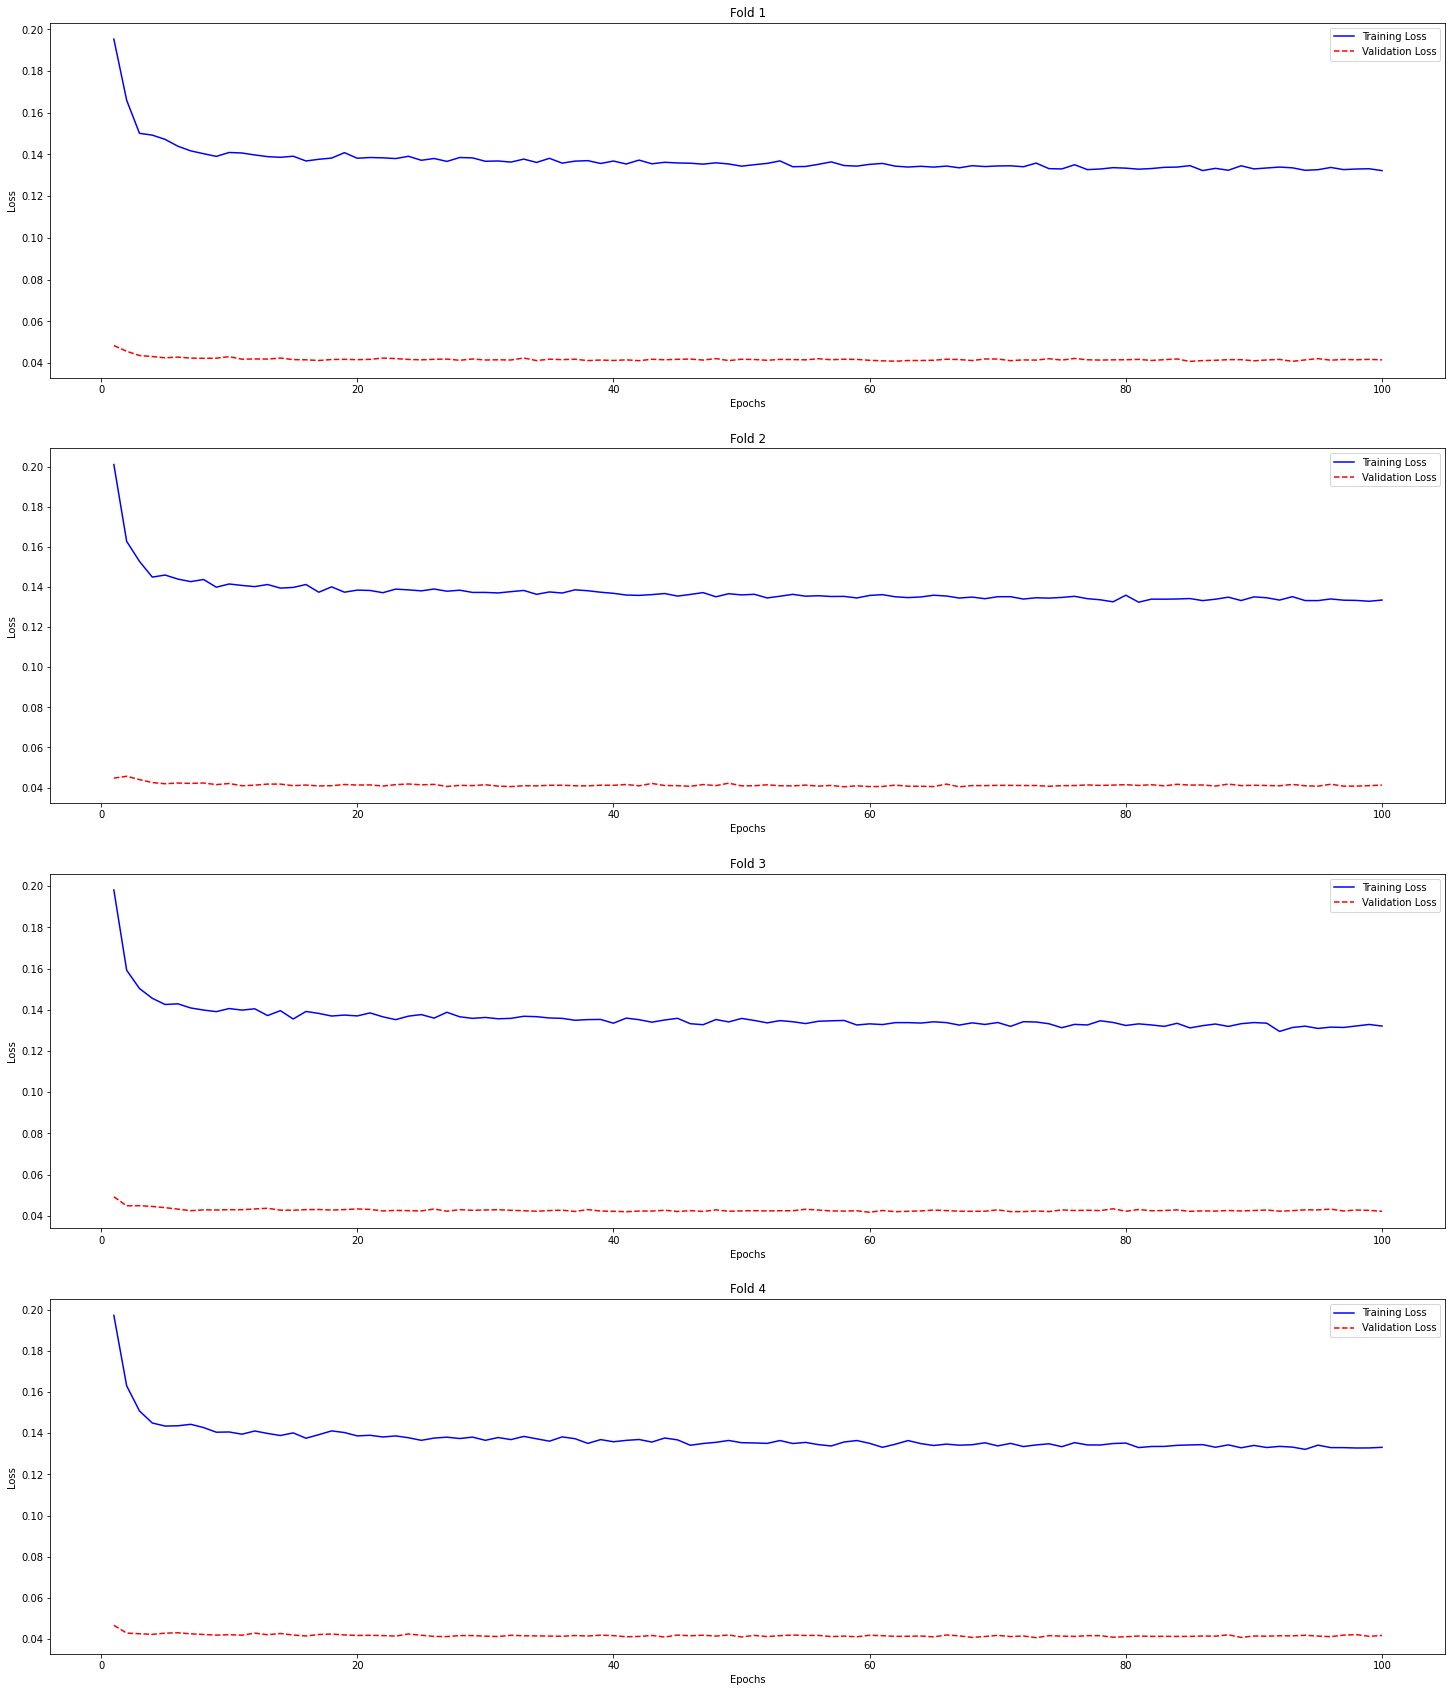

In [15]:
LPT = []
LPV = []

for i in range(len(LP)):
  LPT.append(LP[i]["train"])
  LPV.append(LP[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(25, 30))
for fold in range(4):
    plt.subplot(4, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

**Evaluation on Test Set**

In [16]:
ts_data_setup = DS(X_test, y_test)
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = eval_fn(Network, Names, ts_data)

breaker()
print("ANN Model Accuracy  : {:.5f} %".format(accuracy_score(y_test, y_pred) * 100))
print("F1 Score            : {:.6f} ".format(f1_score(y_test, y_pred)))
breaker()


------------------------------

ANN Model Accuracy  : 84.67019 %
F1 Score            : 0.645051 

------------------------------

